In [1]:
%matplotlib inline
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import pandas as pd
from sctools import integrate, plot, io

Global seed set to 0


# Annotate celltypes with celltypist

In [2]:
adata = sc.read_h5ad(
    '../data/tissue.scps.integrated.clustered.h5ad'
)
adata

AnnData object with n_obs × n_vars = 332546 × 4000
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'coarse_cell_types_colors', 'hvg', 'leiden', 'leiden_scvi_0.1_colors', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModification

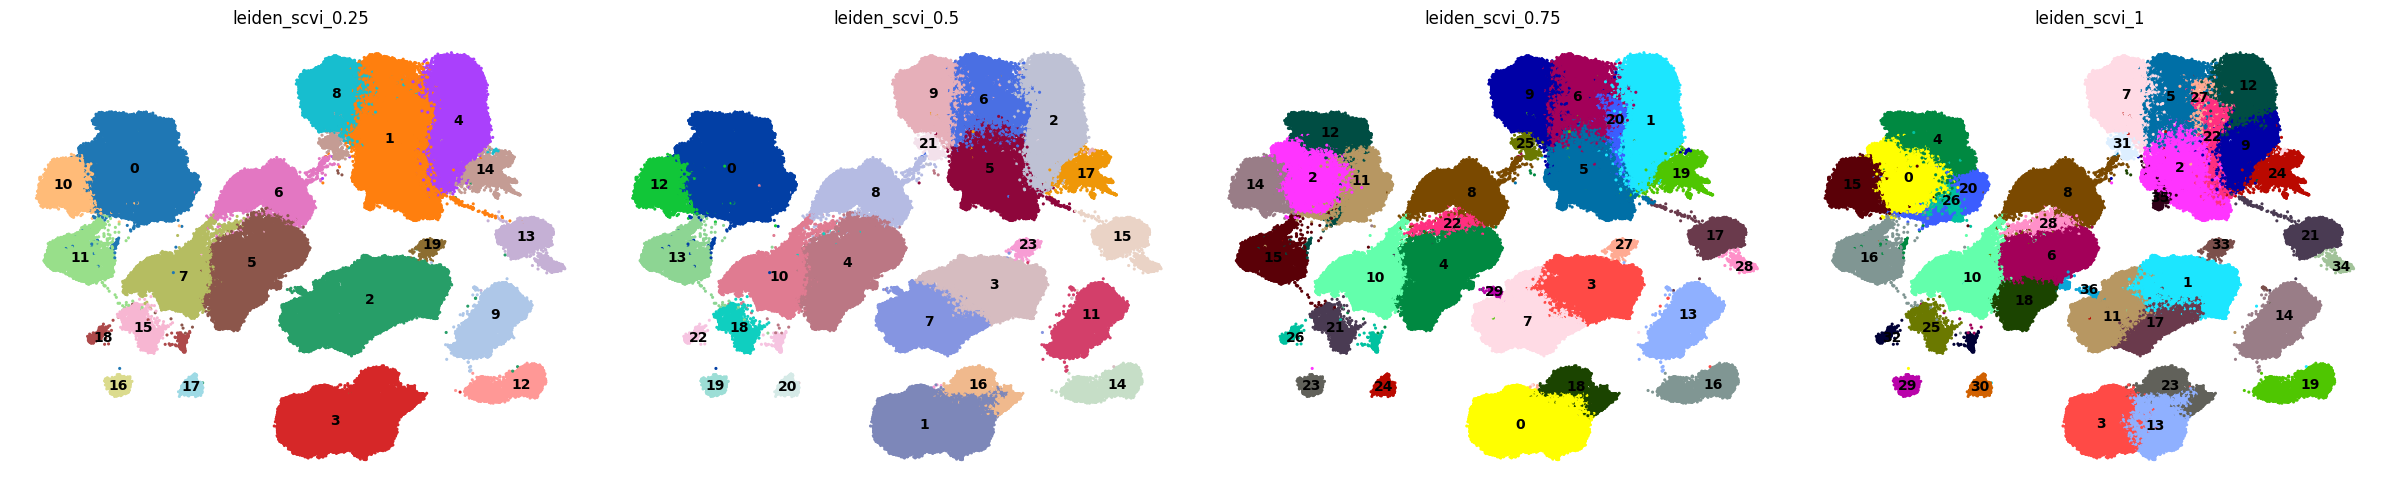

In [7]:
%matplotlib inline
fig, axs = plot.integrate.plot_leiden_clusterings(
    {'full': adata},
    [0.25, 0.5, 0.75, 1],
    legend_loc = 'on data',
    size = 20
)
fig.savefig('../plots/tissue.scps.cellchat.cluster.png')
plt.show()

In [8]:
resolution = 0.75
sc.tl.leiden(
    adata, 
    key_added = f'leiden_scvi_{resolution}',
    resolution = resolution
)

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


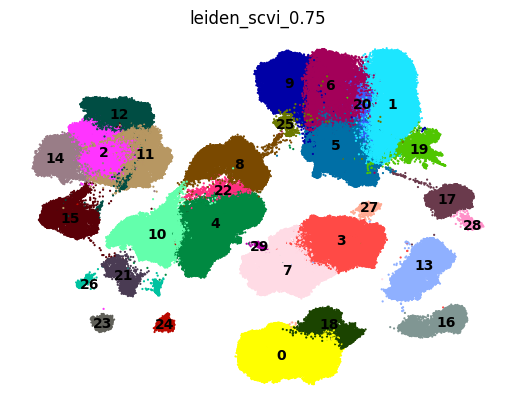

In [12]:
sc.pl.umap(
    adata,
    color = f'leiden_scvi_{resolution}',
    legend_loc = 'on data',
    frameon = False,
    size = 10
)

In [13]:
import importlib
importlib.reload(io)

<module 'sctools.io' from '/groups/pavri/bioinfo/daniel/Neuwirth_Malzl_et_al_2024/notebooks/sctools/io.py'>

In [23]:
bdata = io.initialize_from_raw(adata)
sc.pp.normalize_total(
    bdata,
    target_sum = 1e4
)
sc.pp.log1p(bdata)

/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [24]:
import celltypist as ct
model = ct.models.Model.load(model = 'Adult_Human_Skin.pkl')
model

CellTypist model with 34 cell types and 3295 features
    date: 2023-09-22 18:13:10.902604
    details: cell types from human healthy adult skin
    source: https://doi.org/10.1126/science.aba6500
    version: v1
    cell types: DC1, DC2, ..., moDC
    features: ISG15, TNFRSF18, ..., MT-CYB

In [25]:
predictions = ct.annotate(
    bdata, 
    model = 'Adult_Human_Skin.pkl', 
    majority_voting = True,
    over_clustering = 'leiden_scvi_0.75'
)

🔬 Input data has 332546 cells and 20912 genes
🔗 Matching reference genes in the model
🧬 3295 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [26]:
cdata = predictions.to_adata()

In [27]:
adata.obs['cell_type'] = cdata.obs.majority_voting

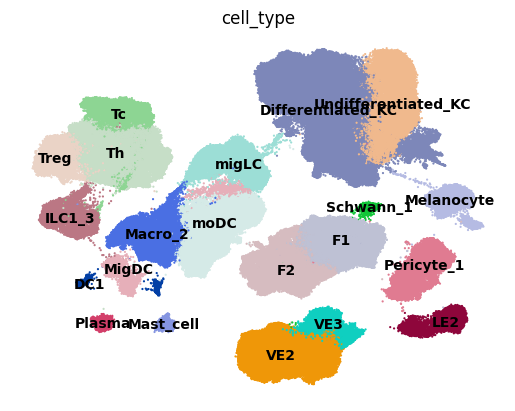

In [28]:
%matplotlib inline
sc.pl.umap(
    adata,
    color = 'cell_type',
    legend_loc = 'on data',
    frameon = False,
    size = 10
)

In [29]:
adata.write('../data/tissue.scps.integrated.annotated.h5ad')

In [ ]:
io.write_sc_data(
    adata,
    '../cellchat/tissue.scps',
    obs_columns = ['sample_id', 'status', 'tissue', 'cell_type']
)